In [8]:
"""
This file contains the code for EDA of the PIE dataset.
"""
import os
import sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from datasets import load_dataset

ds = load_dataset("UB-CVML-Group/PIE_Bench_pp", "0_random_140")
ds.keys()

dict_keys(['V1'])

In [18]:
sample_1 = ds["V1"][0]
sample_1

{'image': <PIL.Image.Image image mode=RGB size=512x512>,
 'id': '000000000000',
 'source_prompt': 'a slanted mountain bicycle on the road in front of a building',
 'target_prompt': 'a slanted [rusty] mountain [motorcycle] in front of a [fence]',
 'edit_action': '{"rusty": {"position": 2, "edit_type": 7, "action": "+"}, "motorcycle": {"position": 3, "edit_type": 1, "action": "bicycle"}, "fence": {"position": 11, "edit_type": 8, "action": "building"}, "on the road": {"position": 4, "edit_type": 3, "action": "-"}}',
 'aspect_mapping': '{"motorcycle": ["rusty"], "fence": [], "road": []}',
 'blended_words': '["bicycle,motorcycle", "building,fence", "road,"]',
 'mask': '0 262144'}

ID: 000000000000
source_prompt: a slanted mountain bicycle on the road in front of a building
target_prompt: a slanted [rusty] mountain [motorcycle] in front of a [fence]


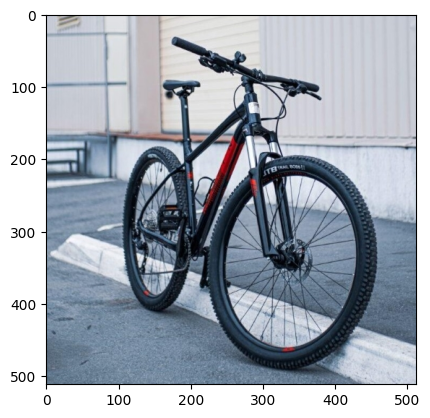

In [23]:
import matplotlib.pyplot as plt
image = sample_1['image']
id = sample_1['id']
source_prompt = sample_1['source_prompt']
target_prompt = sample_1['target_prompt']

print(f"ID: {id}")
print(f"source_prompt: {source_prompt}")
print(f"target_prompt: {target_prompt}")
plt.imshow(image)


In [30]:
import json

# Variations in edit
edit = json.dumps(json.loads(sample_1['edit_action']), indent=2)
print(edit)

{
  "rusty": {
    "position": 2,
    "edit_type": 7,
    "action": "+"
  },
  "motorcycle": {
    "position": 3,
    "edit_type": 1,
    "action": "bicycle"
  },
  "fence": {
    "position": 11,
    "edit_type": 8,
    "action": "building"
  },
  "on the road": {
    "position": 4,
    "edit_type": 3,
    "action": "-"
  }
}


In [32]:
from collections import Counter

actions = []
for sample in ds["V1"]:
    edit_action = json.loads(sample['edit_action'])
    for v in edit_action.values():
        actions.append(v['action'])

action_counts = Counter(actions)
print("Available action types and their counts:")
for action, count in action_counts.items():
    print(f"{action}: {count}")

Available action types and their counts:
+: 124
bicycle: 1
building: 1
-: 3
round: 1
orange frosting: 1
wooden: 5
cat: 6
sitting: 16
flower: 2
orange: 2
coffee: 1
tulip: 2
stands: 1
closed: 1
golden retriever: 1
dog: 6
white background: 2
goat: 2
standing: 7
colorful: 3
bird: 8
branch: 3
meat balls: 1
ceramics: 1
dumplings: 1
brown: 2
black: 5
hanging down: 1
white: 3
fruits: 1
steak: 1
statue: 1
in front view: 1
liberty: 1
torch: 1
tiger: 1
brown ground: 1
birds: 1
parrots: 1
city: 2
van: 1
surfboards: 1
gray: 1
horse: 3
running: 3
blue: 5
shirt: 2
beak: 1
opened eyes: 1
wooden floor: 1
sky background: 1
kitten: 1
walking: 1
grass: 3
stream: 1
forest: 1
red: 6
rose: 2
dark: 2
pink: 2
flowers: 5
cartoon: 2
autumn: 2
duck: 2
water: 3
photograph: 1
window: 1
smoke: 2
withered: 1
green: 2
dress: 1
ducks: 2
dirt: 1
beads: 1
scarf: 1
wolf: 3
large: 1
cargo: 1
illustration: 1
laughing: 1
painting: 1
clouds: 4
rusty: 1
car: 1
bright: 1
clods: 1
black background: 2
camera: 1
bed: 2
snow: 3
mee

In [33]:
from collections import Counter

# Count number of edit actions per sample
edit_counts = [len(json.loads(sample['edit_action'])) for sample in ds["V1"]]

# Maximum number of edit actions in any sample
max_edits = max(edit_counts)
print(f"Maximum number of edit actions in a sample: {max_edits}")

# Count how many images have 3 edits, 2 edits, etc.
edit_count_distribution = Counter(edit_counts)
print("Number of images by edit count:")
for num_edits, num_images in sorted(edit_count_distribution.items()):
    print(f"{num_edits} edits: {num_images} images")

Maximum number of edit actions in a sample: 5
Number of images by edit count:
2 edits: 23 images
3 edits: 105 images
4 edits: 11 images
5 edits: 1 images


In [34]:
# Filter the dataset to include only samples where at least one edit_action has edit_type == 3
def has_edit_type_3(sample):
    edit_action = json.loads(sample['edit_action'])
    return any(v['edit_type'] == 3 for v in edit_action.values())

edit_type_3_ds = ds["V1"].filter(has_edit_type_3)
print(f"Number of samples with at least one edit_type == 3: {len(edit_type_3_ds)}")

Filter: 100%|██████████| 140/140 [00:00<00:00, 569.12 examples/s]

Number of samples with at least one edit_type == 3: 3


In [49]:
import json
from datasets import load_dataset

def load_and_process_dataset(path, split="train"):
    # Load dataset
    ds = load_dataset(path, split)
    
    def has_three_edits(sample):
        edit_actions = json.loads(sample['edit_action'])
        return len(edit_actions) == 3

    # Keep only samples with exactly 3 edits
    ds = ds.filter(has_three_edits)

    def process_edits(sample):
        edit_actions = json.loads(sample['edit_action'])
        sorted_edits = sorted(edit_actions.items(), key=lambda x: x[1]['position'])
        
        current_prompt = sample['source_prompt']
        result = dict(sample)
        
        # Apply edits one by one
        for i, (word, edit) in enumerate(sorted_edits, start=1):
            if edit['action'] == '+':
                words = current_prompt.split()
                words.insert(edit['position'] - 1, word)
                current_prompt = ' '.join(words)
            elif edit['action'] == '-':
                current_prompt = current_prompt.replace(word, '')
                current_prompt = ' '.join(current_prompt.split())
            else:
                current_prompt = current_prompt.replace(edit['action'], word)
            
            result[f"edit_{i}_prompt"] = current_prompt
        
        return result

    # Apply the processing
    ds = ds.map(process_edits)
    return ds

In [51]:
processed_ds = load_and_process_dataset("UB-CVML-Group/PIE_Bench_pp", "0_random_140")
print(processed_ds)

DatasetDict({
    V1: Dataset({
        features: ['image', 'id', 'source_prompt', 'target_prompt', 'edit_action', 'aspect_mapping', 'blended_words', 'mask', 'edit_1_prompt', 'edit_2_prompt', 'edit_3_prompt'],
        num_rows: 105
    })
})


In [ ]:

from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from datasets import DatasetDict
processed_ds.push_to_hub("SRDdev/AI-TextImageEdit")